# Data Science Interview

## Take Home: New Items

### Luisa Benavides Vargas


### Octubre 2022

### Requerido

- **Data QA:** Se debe chequear la calidad del dataset para hacer una evaluación de qué tan apropiados son los datos para tareas de Data Science. Proponga un conjunto de correcciones en los datos de ser necesario.
- **Reporting:** Documente los resultados e insights obtenidos durante la exploración y describa conclusiones desde una perspectiva de negocio, soportado por gráficos / tablas / métricas.
- **Feature Engineering:** Indicar y calcular posibles candidatos de features que podrían utilizarse para predecir los ítems semejantes, tanto desde las columnas originales como desde transformaciones.
- **Modelo predictivo:** Realice un modelo predictivo capaz de encontrar los 5 ítems más semejantes (proponga una definición de semejanza que considere el negocio de Mercado Libre).

In [88]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import string
import re
from kmodes.kmodes import KModes
from sklearn import preprocessing
from sentence_transformers import SentenceTransformer, util
from collections import Counter
import math
import io
import torch
from operator import index
from sklearn.metrics.pairwise import euclidean_distances
import csv
import joblib

In [89]:
# Cargar datos
new_items = pd.read_csv("new_items_dataset-v202205.csv", encoding='latin-1')
new_items.head(2)

C:\Users\lufbenav\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning:

Columns (7,14,15) have mixed types.Specify dtype option on import or set low_memory=False.



,id,title,date_created,base_price,price,category_id,tags,seller_id,seller_country,seller_province,...,shipping_mode,shipping_admits_pickup,shipping_is_free,status,sub_status,warranty,is_new,initial_quantity,sold_quantity,available_quantity
0,MLA578569012,Escritorio Secretter Espectacular,2015-09-08T21:17:57.000Z,6700.0,6700.0,MLA1902,['dragged_bids_and_visits'],99151748,Argentina,Buenos Aires,...,custom,True,False,active,NaN,NaN,0,1.0,0.0,1.0
1,MLA576883746,Stassen Espatulas Milenio Numero 3 Codigo 590-3,2015-08-29T12:55:03.000Z,119.0,119.0,MLA3530,['dragged_bids_and_visits'],65545512,Argentina,Capital Federal,...,not_specified,False,False,active,NaN,SÃ­,1,19.0,0.0,19.0


### **Data QA:** 
Se debe chequear la calidad del dataset para hacer una evaluación de qué tan apropiados son los datos para tareas de Data Science. Proponga un conjunto de correcciones en los datos de ser necesario.

In [90]:
# Revisar tipo de datos
new_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      99996 non-null   object 
 1   title                   99996 non-null   object 
 2   date_created            99996 non-null   object 
 3   base_price              99996 non-null   float64
 4   price                   99992 non-null   float64
 5   category_id             99996 non-null   object 
 6   tags                    99996 non-null   object 
 7   seller_id               99996 non-null   object 
 8   seller_country          99993 non-null   object 
 9   seller_province         99993 non-null   object 
 10  seller_city             99992 non-null   object 
 11  seller_loyalty          99996 non-null   object 
 12  buying_mode             99996 non-null   object 
 13  shipping_mode           99996 non-null   object 
 14  shipping_admits_picku

Substatus tiene una alta cantidad de valores nulos. Warranty también pero puede ser usada como variable categórica.

In [91]:
# Eliminar nulos y columnas con poca informacion
df = new_items.copy().drop(columns=["sub_status"])
df.warranty = df.warranty.fillna('0')
df = df.dropna().reset_index()

In [92]:
# definir datatypes
## numerico
list_num = pd.Series([
    "base_price",
    "price",
    "initial_quantity",	
    "sold_quantity",	
    "available_quantity"
])
for col in list_num:
    df[col] = df[col].astype('float64')

## categoria
list_cat = pd.Series([
    "category_id",	
    "tags",	
    "seller_country",	
    "seller_province",	
    "seller_city",	
    "seller_loyalty",	
    "buying_mode",	
    "shipping_mode",	
    "shipping_admits_pickup",	
    "shipping_is_free",	
    "status",
    "is_new"
])
for col in list_cat:
    df[col] = df[col].astype('category')

## texto
list_txt = pd.Series([
    "id",
    "title",
    "warranty",
    "seller_id"
])
for col in list_txt:
    df[col] = df[col].astype('string')

## date
df['date_created'] = pd.to_datetime(df['date_created'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99988 entries, 0 to 99987
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   index                   99988 non-null  int64              
 1   id                      99988 non-null  string             
 2   title                   99988 non-null  string             
 3   date_created            99988 non-null  datetime64[ns, UTC]
 4   base_price              99988 non-null  float64            
 5   price                   99988 non-null  float64            
 6   category_id             99988 non-null  category           
 7   tags                    99988 non-null  category           
 8   seller_id               99988 non-null  string             
 9   seller_country          99988 non-null  category           
 10  seller_province         99988 non-null  category           
 11  seller_city             99988 non-null  c

In [93]:
df2 = pd.DataFrame()
for x in list_cat:
    df_new = pd.DataFrame(columns=["ndif", "col", "variable", "frecuencia"])
    df_conteo = df[x].value_counts(normalize=True)
    df_new["variable"] = df_conteo.index
    df_new["frecuencia"] = df_conteo.values
    df_new["col"] = x
    df_new["ndif"] = df[x].nunique()
    df_new = df_new.sort_values(by=["frecuencia"], ascending=False).head(3)
    df2 = df2.append(df_new, ignore_index=True)
df2

,ndif,col,variable,frecuencia
0,10907,category_id,MLA1227,0.045936
1,10907,category_id,MLA2044,0.019492
2,10907,category_id,MLA41287,0.009321
3,8,tags,['dragged_bids_and_visits'],0.725497
4,8,tags,[],0.249120
5,8,tags,"['good_quality_thumbnail', 'dragged_bids_and_v...",0.013302
6,1,seller_country,Argentina,1.000000
7,24,seller_province,Capital Federal,0.578539
8,24,seller_province,Buenos Aires,0.350162
9,24,seller_province,Santa Fe,0.026723


Para las variables categóricas es útil revisar la frecuencia que presenta cada uno de los valores que puede tomar la categoría. Esto permite saber cuales son los valores que dominan cada variable. De la revisión anterior de la frecuencia se nota que: 

1. tags: está dominado por un mismo valor "['dragged_bids_and_visits']" 
2. seller_country: Todos los artículos son de Argentina 
3. seller_province: 93% son de "Ciudad Federal" y "Buenos Aires"
4. seller_city: 3655 ciudades 
5. buying_mode: 97% de los ítems son buy it now 
6. shipping_mode: 45% de los ítems no especifican el método de envío
7. shipping_is_free: solo se especifica True para el 2% de los ítems
8. status: el 95% de las publicaciones están activas

Teniendo en cuenta esta información observada no se tendrán en cuenta para el análisis las variables ya que están principalmente definidas por el mismo valor: tags, seller_country, buying_mode, shipping_is_free, status. 

Para las demás categorías como provincia, ciudad, shipping_mode se puede realizar una reclasificación de las entradas de cada campo para que siempre estén dentro de un rango de variables predefinidas. Por ejemplo para provincia se pueden definir los valores "Ciudad Federal", "Buenos Aires" y "Otras Provincias", esto con el fin de reducir la dimensionalidad de cada columna. 

In [94]:
# elimnar col 
df_items = df.drop(columns=["index", "tags", "seller_country", "buying_mode", "shipping_is_free", "status"])

### **Reporting:** 

Documente los resultados e insights obtenidos durante la exploración y describa conclusiones desde una perspectiva de negocio, soportado por gráficos / tablas / métricas.

### **Feature Engineering:** 

Indicar y calcular posibles candidatos de features que podrían utilizarse para predecir los ítems semejantes, tanto desde las columnas originales como desde transformaciones.

--------------------------------------------------

Fueron 17 columnas resultantes del análisis de la calidad de los datos. Sobre estos datos se realiza el análisis exploratorio de los datos y el posterior modelo de predicción. 

In [95]:
df_items.columns

Index(['id', 'title', 'date_created', 'base_price', 'price', 'category_id',
       'seller_id', 'seller_province', 'seller_city', 'seller_loyalty',
       'shipping_mode', 'shipping_admits_pickup', 'warranty', 'is_new',
       'initial_quantity', 'sold_quantity', 'available_quantity'],
      dtype='object')

#### Variables numéricas

- Correlación de variables numéricas: 

<AxesSubplot:>

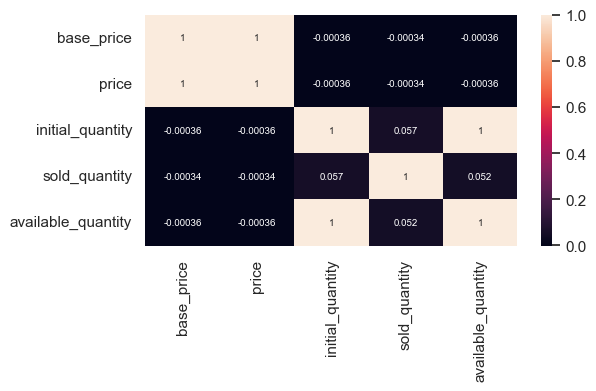

In [96]:
# corr
sns.set(rc={'figure.figsize':(6,3)})
sns.heatmap(df_items.corr(), annot=True, annot_kws={"size": 7})

In [97]:
print("Precio base diferente a precio inicial: ", 
    df_items["id"][df_items["price"] != df_items["base_price"]].count())
print("Cantidades vendidas mayor al inventario incial: ", 
    df_items["id"][df_items["sold_quantity"] > df_items["initial_quantity"]].count())
print("Inventario real diferente a lo reportado en available_quantity: ", 
    df_items["id"][df_items["initial_quantity"]-df_items["sold_quantity"] != df_items["available_quantity"]].count())

Precio base diferente a precio inicial:  29
Cantidades vendidas mayor al inventario incial:  6005
Inventario real diferente a lo reportado en available_quantity:  15323


A partir de la gráfica se observa que no hay correlación entre las variables, excepto por el precio y precio base. En este caso se tiene que ambos valores son similares en la mayoría de los casos, solo 29 ítems presentan diferencias, por lo tanto esta columna también puede ser eliminada.

Además con los cálculos realizados se puede comprobar que las variables correspondientes a las cantidades vendidas y el inventrio disponible en algunos casos no corresponde con la realidad. Para este caso estas variables son útiles para la construcción de variables adicionales que podrían aportar al resultado: 
- cantidad vendida ("**sold_quantity**") 
- monto vendido. Esta variable se puede construir a partir de la cantidad vendida y el precio, puede indicar si los items son de alto o bajo valor. **sold_amount** = sold_quantity*price
- si hay o no inventario disponible, esta variable redefinida a partir de las disponibles ("initial_quantity"-"sold_quantity" = "available_quantity"), si available_quantity es mayor 1 la variable indicativa tomaría el valor de 1, por el contrario sería 0. Esta variable será llamada **is_available**

In [98]:
# is_available
df_items["available_quantity2"] = df_items.initial_quantity - df_items.sold_quantity
df_items["is_available"] = np.where(df_items.available_quantity2 > 0, 1, 0)
# sold_amount 
df_items["sold_amount"] = df_items.sold_quantity * df_items.price
df_items = df_items.drop(columns=["base_price", "initial_quantity", "available_quantity", "available_quantity2"])

#### Variables categóricas

- Identificar categorías dentro de cada variable
- Limpiar datos para que las categorías sean consistentes
- Binning de categorias: unir niveles

<AxesSubplot:>

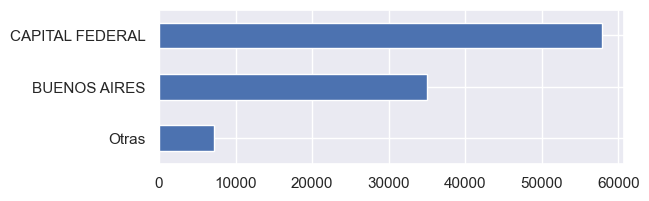

In [99]:
# seller_province (Capital Federal, Buenos Aires, Otras)
plt.subplots(figsize=(6,2))
df_items["seller_province"] = np.where(df_items["seller_province"]=="Capital Federal", "CAPITAL FEDERAL", 
np.where(df_items["seller_province"]=="Buenos Aires", "BUENOS AIRES", "Otras"))
df_items.seller_province.value_counts().sort_values().plot(kind = 'barh')


In [100]:
# seller_city
df_items["seller_city"] = df_items['seller_city'].str.upper().str.translate(str.maketrans('', '', string.punctuation))

<AxesSubplot:>

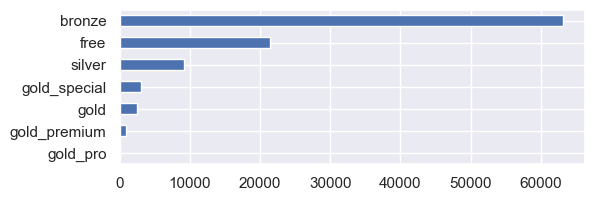

In [101]:
# seller_loyalty
plt.subplots(figsize=(6,2))
df_items.seller_loyalty.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

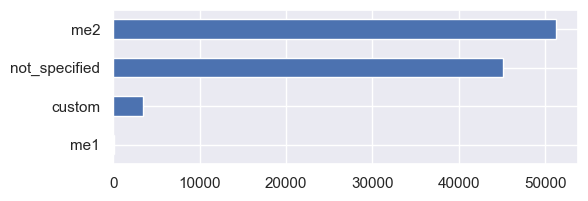

In [102]:
# shipping_mode: Binning
plt.subplots(figsize=(6,2))
df_items.shipping_mode.value_counts().sort_values().plot(kind = 'barh')

Unir me1 y me2 (envios Mercado Libre) en un solo grupo y los demás en otro que corresponda a not_specified y custom.

<AxesSubplot:>

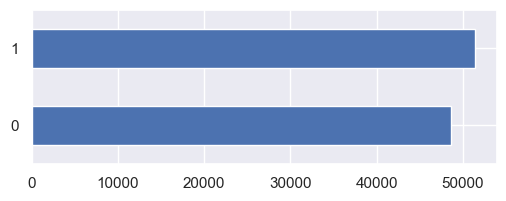

In [103]:
plt.subplots(figsize=(6,2))
df_items["shipping_mode_me"] = np.where(df_items.shipping_mode == "me1", 1, np.where(df_items.shipping_mode == "me2", 1, 0))
df_items = df_items.drop(columns=["shipping_mode"])
df_items.shipping_mode_me.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

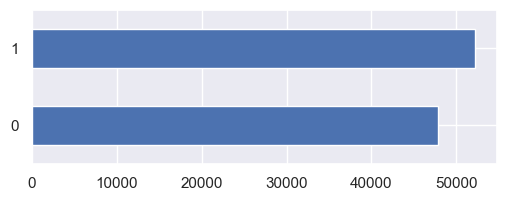

In [104]:
# shipping_admits_pickup
plt.subplots(figsize=(6,2))
df_items.shipping_admits_pickup = np.where(df_items.shipping_admits_pickup.str.upper() == "TRUE",1,0)
df_items.shipping_admits_pickup.value_counts().sort_values().plot(kind = 'barh')

<AxesSubplot:>

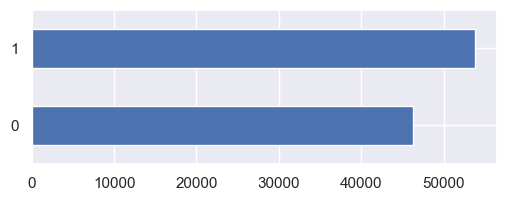

In [105]:
# is_new
plt.subplots(figsize=(6,2))
df_items.is_new = df_items.is_new.astype('int')
df_items.is_new.value_counts().sort_values().plot(kind = 'barh')

#### Variables de texto

- Corrección de formato
- Texto en minúsculas
- Eliminar puntuación de variables de texto
- Para warranty crear variable que indique si el item ofrece o no garantía

In [106]:
# title: Cleaning
df_items.title = df_items.title.str.lower().str.translate(str.maketrans('', '', string.punctuation))

<AxesSubplot:>

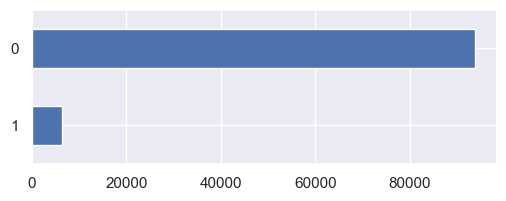

In [107]:
# warranty: Imputing and Binning
plt.subplots(figsize=(6,2))
df_items.warranty = df_items.warranty.str.lower().str.translate(str.maketrans('', '', string.punctuation))
# buscar meses y años de garantia
df_items["warranty2"] = df_items.warranty.str.extract('([0-9]+ aã±o)', expand=True)
df_items["warranty3"] = df_items.warranty.str.extract('([0-9]+ mes)', expand=True)
df_items["warranty3"] = df_items.warranty3.fillna(df_items.warranty2)
# var dummy de garantia
df_items.warranty = np.where(df_items.warranty3.isna() == True, 0, 1)
df_items = df_items.drop(columns=["warranty2", "warranty3"])
df_items.warranty.value_counts().sort_values().plot(kind = 'barh')

#### Variables de fecha

- Rango de fecha
- Cantidad de items en el tiempo

In [108]:
# rago de fechas
print("Rango de fechas: ", df["date_created"].min(), "-", df["date_created"].max())

Rango de fechas:  2013-05-21 04:22:35+00:00 - 2015-10-15 09:14:30+00:00


In [109]:
# ventas por año
print("Suma de ventas por año: ", df_items.sold_quantity.groupby(df["date_created"].dt.year).sum())

Suma de ventas por año:  date_created
2013         0.0
2014         0.0
2015    239697.0
Name: sold_quantity, dtype: float64


In [110]:
# ventas por año
print("Conteo de ventas por año: ", df_items.sold_quantity.groupby(df["date_created"].dt.year).count())

Conteo de ventas por año:  date_created
2013        9
2014      120
2015    99859
Name: sold_quantity, dtype: int64


Se indentifica que hay un total de 129 registros creados en los año 2013 y 2014, adicionalmente estos reportes no tienen ninguna venta asociada. Por lo tanto la fecha en este caso, no estaría aportado información.

In [111]:
df_items = df_items.drop(columns=["date_created"])

Una vez se realiza el análisis y transformación de todas las variables disponibles y a partir de estas se crean algunas nuevas, se tiene el siguiente conjunto de variables: 

In [112]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99988 entries, 0 to 99987
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      99988 non-null  string  
 1   title                   99988 non-null  string  
 2   price                   99988 non-null  float64 
 3   category_id             99988 non-null  category
 4   seller_id               99988 non-null  string  
 5   seller_province         99988 non-null  object  
 6   seller_city             99988 non-null  object  
 7   seller_loyalty          99988 non-null  category
 8   shipping_admits_pickup  99988 non-null  int32   
 9   warranty                99988 non-null  int32   
 10  is_new                  99988 non-null  int32   
 11  sold_quantity           99988 non-null  float64 
 12  is_available            99988 non-null  int32   
 13  sold_amount             99988 non-null  float64 
 14  shipping_mode_me      

A partir de esta infromación "limpia" y con las dimensiones reducidas se pueden realizar varios análisis exploratorios de los datos que permitan entender mucho mejor el contexto en el que los datos están descritos. 

Primero veamos como se comportan las ventas dependiendo del nivel de loyality del vendedor. 

C:\Users\lufbenav\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



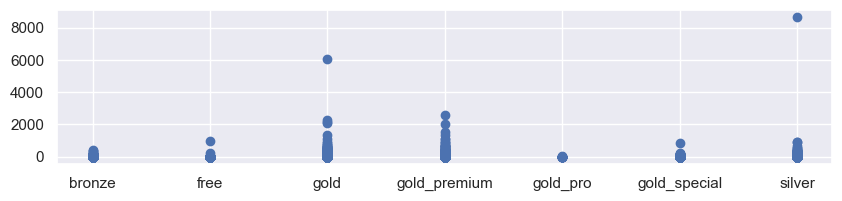

In [113]:
# plot
fig, ax = plt.subplots(figsize=(10,2))
ax.plot('seller_loyalty', 'sold_quantity', data=df_items.sort_values(by=["seller_loyalty"]), linestyle='none', marker='o')
fig.show()

Hay algunos valores de ventas altos que no permiten observar la tendencia de las ventas. En la siguiente lista se puede ver que son 13 casos en lo que esto ocurre. Para mejorar la visualización se pueden filtrar y calcular la media de las ventas para cada nivel de loyality de los vendedores. 

También se puede observar para cada nivel no solo el promedio de ventas sino también la cantidad de items registrados.

In [114]:
df_items_bar = df_items[df_items.sold_quantity < 1000]
dff = df_items_bar[['seller_loyalty','sold_quantity']].groupby(['seller_loyalty'], as_index=False).mean().set_index('seller_loyalty').reset_index().sort_values('sold_quantity',ascending = False)
fig = px.bar(dff, x='seller_loyalty', y='sold_quantity', color = 'seller_loyalty',
            color_discrete_sequence=px.colors.qualitative.Safe,
            title = 'Seller loyality vs Mean Sold Quantity', 
            width=800, height=400)
fig.update_layout(xaxis_title="Seller loyality", yaxis_title="Mean Sold Quantity")
fig.show()

dff = df_items_bar[['seller_loyalty','sold_quantity']].groupby(['seller_loyalty'], as_index=False).count().set_index('seller_loyalty').reset_index().sort_values('sold_quantity',ascending = False)
fig = px.bar(dff, x='seller_loyalty', y='sold_quantity', color = 'seller_loyalty',
            color_discrete_sequence=px.colors.qualitative.Safe,
            title = 'Seller loyality vs Item Quantity', 
            width=800, height=400)
fig.update_layout(xaxis_title="Seller loyality", yaxis_title="Item Quantity")
fig.show()

De lo anterior se observa que las categorías gold y premium gold son las que realizan en promedio máyor cantidad de ventas. Pero las categorías bronze y free son las que mayor cantidad de items registran. Esto indica que el nivel de loyality afecta la desición de compra de los usuarios aún teniendo muchas opciones de otros vendedores que no tengas estos niveles de loyality.

#### 

**Modelo predictivo:** 

Realice un modelo predictivo capaz de encontrar los 5 ítems más semejantes (proponga una definición de semejanza que considere el negocio de Mercado Libre).

------------

#### 

**Medida de distancia entre puntos representados por cada elemento:**

Para calcular la semejanza entre un elemento y otro se realiza la medición de la distancia de cada para de elementos usando los atributos definidos por las variables disponibles. Para ellos las variables deben ser numéricas y estar en la misma escala.

- Volver numéricas todas las variables
- Scaling/Normalizar
--------
Por medio del preprosesamiento de las variables realizado hasta este punto solo quedan por procesar 7 variables. Para id no es necesario realizar procesamiento ya que es el identificador único, para las demás a continuación se indica que se hará en cada caso:

- id (solo se debe verificar que cada elemento nuevo tenga un id y no esté vacío)
- title (word embeddings para identifiar la semejanza entre frases)
- category_id (variable categórica con múltiple niveles, modelo de kmodes)
- seller_province (variable categórica con pocos niveles, dummy)
- seller loyality (variable categórica con pocos niveles, dummy)
- seller_id (variable categórica con múltiple niveles, modelo de kmodes)
- seller_city (variable categórica con múltiple niveles, modelo de kmodes)

Para las variables category_id, seller_id y seller_city se tienen múltiples niveles y no resulta eficiente tratarlas como las demás categóricas donde solo se realiza un encoding de cada nivel. Por lo tanto previo a la predicción de los items más similares, se realizará un modelo de clustering usando **kmodes** para agrupar los elementos en categorías más sencillas.

In [115]:
# Var cat to dummy
df_items_dum = pd.get_dummies(df_items,columns=["seller_province", "seller_loyalty"])

**K Modes Clusterign**

Este método es similar a k means pero agrupa los elementos basándose en la cantidad de coincidencias entre las categorías que haya para cada elemento. Se realiza sobre variables categóricas es resulta útil en este caso que tenemos variables de dimensiones altas. El proceso seguido es el siguiente: 
1. Crear DF solo con las variables categóricas de interes
2. Escoger la cantidad óptima de k
3. Ejecutar el modelo para esta cantidad de k
4. Revisar la distribución de los elementos dentro de los cluster

In [116]:
df_items_cat = df_items[["category_id", "seller_id", "seller_city"]]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 287946.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 279777.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 272652.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 272195.0


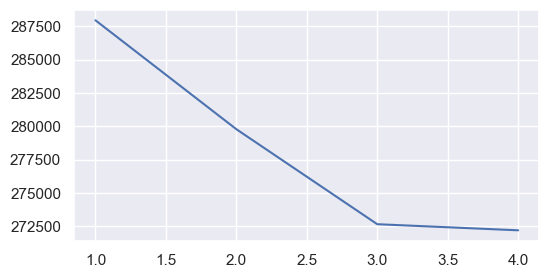

In [117]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(df_items_cat)
    cost.append(kmode.cost_)
    
# graficar el costo 
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

A partir de esta información se selecciona el núero de clusters como 3. 

In [118]:
# kmodes clustering 
km = KModes(n_clusters=3, verbose=1)

Initialization method and algorithm are deterministic. Setting n_init to 1.


In [119]:
clusters = km.fit_predict(df_items_cat)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 272652.0
[['MLA1227' '52340590' 'CABA']
 ['MLA2044' '58869788' 'BUENOS AIRES']
 ['MLA41287' '76404673' 'CAPITAL FEDERAL']]


El modelo entrenado se guarda en un .joblib para usarlo después y no repetir este paso en el proceso final.

In [85]:
# save the model
joblib.dump(km, "model_kmodes.joblib")

['model_kmodes.joblib']

In [86]:
# cargar modelo
model = joblib.load("model_kmodes.joblib")
clusters = model.fit_predict(df_items_cat)

# distribución de los elementos en cada cluster
clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([df_items_cat, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(["index"], axis = 1)
combinedDf.groupby(combinedDf.cluster_predicted).count()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 20, cost: 272652.0


,category_id,seller_id,seller_city
cluster_predicted,,,
0,85471,85471,85471
1,7719,7719,7719
2,6798,6798,6798


In [33]:
# eliminar variables que fueron transformadas
predictionDF = df_items_dum.drop(columns=["category_id", "seller_id", "seller_city"])
predictionDF["cluster_predicted"] = combinedDf.cluster_predicted

#### **Calcular Distancias:**

Una vez se tienen todas las variables procesadas y de forma numérica se realiza el cálculo de las distancias para determinar los elementos más cercanos de un nuevo ítem que se incluya en los datos. 

NOTA: Es importante tener en cuenta en este punto que no se usa la variable de título, solo las variables procesadas previamente. El id no se usa para la predicción ya que es el identificador único de cada elemento. 

**Normalizar variables numéricas**

In [34]:
def mm_norm(col,df):
    """
    Caping de outliers en el percentil 99
    Normaliza una columna usando el metodo min/max
    """
    pd.set_option('mode.chained_assignment', None)
    # caping outliers
    df2 = df[[col]]
    top = df2[col].quantile(0.99)
    df2[col] = np.where(df2[col] > top, top, df2[col])

    # normalization
    x = df2.values 
    transformer = preprocessing.MinMaxScaler()
    x_scaled = transformer.fit_transform(x)
    DFnorm = pd.DataFrame(x_scaled, columns=[col])
    return DFnorm


In [35]:
predictionDF["price"] = mm_norm("price", predictionDF)
predictionDF["sold_amount"] = mm_norm("sold_amount", predictionDF)
predictionDF["sold_quantity"] = mm_norm("sold_quantity", predictionDF)

**Calcular distancias entre elementos**

In [46]:
# convertir datos a vectores
pointXvector = predictionDF.drop(columns=["id", "title"])
pointXvector = pointXvector.values
pointYvector = predictionDF.tail(1).drop(columns=["id", "title"])
pointYvector = pointYvector.values 

# calcular distancia euclidiana entre cada punto 
dist = euclidean_distances(pointXvector, pointYvector)

# recuperar id de los elementos
dist = pd.DataFrame(dist, columns = ["distance"])
pointXDF = predictionDF[["id", "title"]]
pointYDF = predictionDF[["id", "title"]].tail(1)
pointXDF["distance"] = dist.distance
pointXDF["id_new_item"] = pointYDF.id.max()
pointXDF["title_new_item"] = pointYDF.title.max()
similarDF = pointXDF.sort_values(by="distance").head(100)

# set de elementos semejantes
idSimilar = similarDF.id


##### **Resultado para un elemento**

Después de calcular las distancias tenemos el siguiente resultado.

Para el ítem **MLA582542755: el fin de las libertades  benegas lynch h  usado**:

In [48]:
similarDF[1:10]

,id,title,distance,id_new_item,title_new_item
34219,MLA581552540,guerras civiles de granada pã©rez de hita agui...,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
77813,MLA584330990,la lucha por la consolidaccion de la nacion ar...,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
61693,MLA583504664,o melhor de inezita barroso vinilo lp brasileã±o,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
35757,MLA580889189,la mensaje de silo ulrica ediciones 2007 tap...,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
81832,MLA583351230,enrique molinahacia una isla desierta,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
35744,MLA581806196,el compadrito y su alma fernando guibert,0.000000,MLA582542755,el fin de las libertades benegas lynch h usado
69109,MLA579202096,cuentos de la selva horacio quiroga l,0.000004,MLA582542755,el fin de las libertades benegas lynch h usado
59998,MLA580094165,doctrina de monroe y cooperacion internacional,0.000008,MLA582542755,el fin de las libertades benegas lynch h usado
96025,MLA575693646,apollo four forty gettin high on your own sup...,0.000008,MLA582542755,el fin de las libertades benegas lynch h usado
33559,MLA581551241,yanni live at the acropolis cd 69,0.000008,MLA582542755,el fin de las libertades benegas lynch h usado


Se puede identificar que las distancias son iguales o muy cercanas a 0, es decir que para todas las variables contempladas los elementos son iguales. Revisando el título se puede observar que la mayoría corresponden a libros por lo tanto no está errada la similitud. Sin embargo, a partir del contenido del título se podría realizar una mejor diferenciación entre elementos ya que es la única variable de ingreso libre que puede contener cualquier tipo de palabras y permitir diferenciar un elemento de otro.

##### **Calcular similitud entre frases**

Después de encontrar el grupo de elementos más cercanos entre si hallados por medio de la minimización de la distancia euclidiana entre los puntos, se puede realizar el análisis de la similitud entre los párrafos que contiene la variable *title*. Este proceso se realiza solo sobre el grupo previamente escogido por el método de la distancia euclidiana ya que computacionalmente sería muy lento calcularlo sobre todo el data set cada vez que se ingresa un nuevo elemento. 

Este proceso permite calcular la similitud entre dos frases. El modelo usado está basado en el paquete **sentence_transformers** que ha sido entrenado para frases en español. 

Toda la documentación y referencias pueden encontarse en el siguiente link: [sentence_similarity_spanish_es](https://huggingface.co/hiiamsid/sentence_similarity_spanish_es).

Este modelo realiza para cada frase o párrafo un vector de densidad de 768 componentes para describir cada frase, con esta descomposición del texto luego se pueden utilizar diferentes medidas de distancia para determinar la similitud entre dos frases, siendo 1 el valor más alto. 

En este caso este modelo será usado como complemento al cálculo de las distancias, primero al título del nuevo elemento se le calcula la similitud con todos los elementos del data set y los valores resultantes se usan como variable numérica adicional dentro del cálculo de las distancias. 

In [39]:
# cargar modelo
model = SentenceTransformer('sentence_similarity_spanish_es')

El modelo inicialmente calcula todas las características para cada uno de los elementos, esto es un proceso que toma mucho tiempo por lo tanto se realiza una vez y se pueden almacenar el resultado en un archivo externo. 

**** Previamente ejecutado, el arhchivo es de 300 MB y cuenta con el vector de características para cada ítem de la lista, se puede volver a cargar y cada vez que ingrese un elemento nuevo se añade al tensor donde está almacenado. Idealmente este tipo de información estaría almacenada en una base de datos donde pueda ser consultada cada vez que se ejecute el proceso. 

A continuación está descrito el código utilizado para realizar la creación de los vectores de características. 

#### Todos los elementos del dataset
allItemsData = list(predictionDF.title)

#### Embedding
embeddingsAll = model.encode(allItemsData, convert_to_tensor=True)

#### Save to file

torch.save(embeddingsAll, 'tensor_embeddingsAll.pt')

buffer = io.BytesIO()

torch.save(embeddingsAll, buffer)

In [40]:
# cargar tensor de caracteristicas
embeddingsAll = torch.load('tensor_embeddingsAll.pt')

In [65]:
# filtrar tensor 
indices = torch.tensor([similarDF.index.values])
embeddingsFiltered = torch.index_select(embeddingsAll, 0, indices.squeeze())

In [75]:
# reiniciar index de similares
similarDF = similarDF.reset_index()

# Establecer grupo de párrafo de comparación (elemento nuevo)
newItemsDF = predictionDF.tail(1)

# Solo titulos
newItems = list(newItemsDF.title)
newItems = newItems * len(similarDF)

# Embedding
embeddings1 = model.encode(newItems, convert_to_tensor=True)

# Cosine-similarities
cosineScores = util.cos_sim(embeddings1, embeddingsFiltered)
indices = torch.tensor([0])
cosineScores = torch.index_select(cosineScores, 0, indices)
cosineScores = pd.DataFrame(cosineScores.numpy(), index=["sentence_similarity"]).T

In [76]:
# unir al dataframe inicial 
similarDF["sentence_similarity"] = cosineScores

In [82]:
# 5 más similares
similarDF5 = similarDF.sort_values(by="sentence_similarity", ascending=False)
similarDF5 = similarDF5[1:6]

similarDF5

,index,id,title,distance,id_new_item,title_new_item,sentence_similarity
95,49125,MLA574708657,de la necesidad al servicio r braun f frydman...,0.000015,MLA582542755,el fin de las libertades benegas lynch h usado,0.421768
39,53140,MLA576347390,dvd el ãltimo dã­a no manâ´s land de tanovic,0.000015,MLA582542755,el fin de las libertades benegas lynch h usado,0.335028
35,52566,MLA581367102,ciclismoremigio saavedrac de kuysschertapa de ...,0.000015,MLA582542755,el fin de las libertades benegas lynch h usado,0.328369
63,64153,MLA578015991,hambrientas de lucro robert j ledogar,0.000015,MLA582542755,el fin de las libertades benegas lynch h usado,0.327226
75,57910,MLA577738554,divorcio en el aire gonzalo torne,0.000015,MLA582542755,el fin de las libertades benegas lynch h usado,0.325607
